In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import MiniBatchKMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [2]:
X_train = np.loadtxt("https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/812a3f66a744bf99069b49e5162084526f740b2d/02_assignments/ida_lab-07_pca-kmeans/samsung_HAR/samsung_train.txt")
y_train = np.loadtxt("https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/812a3f66a744bf99069b49e5162084526f740b2d/02_assignments/ida_lab-07_pca-kmeans/samsung_HAR/samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/812a3f66a744bf99069b49e5162084526f740b2d/02_assignments/ida_lab-07_pca-kmeans/samsung_HAR/samsung_test.txt")
y_test = np.loadtxt("https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/812a3f66a744bf99069b49e5162084526f740b2d/02_assignments/ida_lab-07_pca-kmeans/samsung_HAR/samsung_test_labels.txt").astype(int)

In [3]:
# Перевіримо розмірності
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

In [4]:
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])

In [5]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [6]:
n_classes = np.unique(y).size

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
pca = PCA(0.90, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

In [9]:
X_pca.shape

(10299, 65)

In [10]:
len(pca.explained_variance_ratio_)#1

65

C:\Users\tksw\AppData\Local\Temp\ipykernel_23228\1639638425.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()#1.1


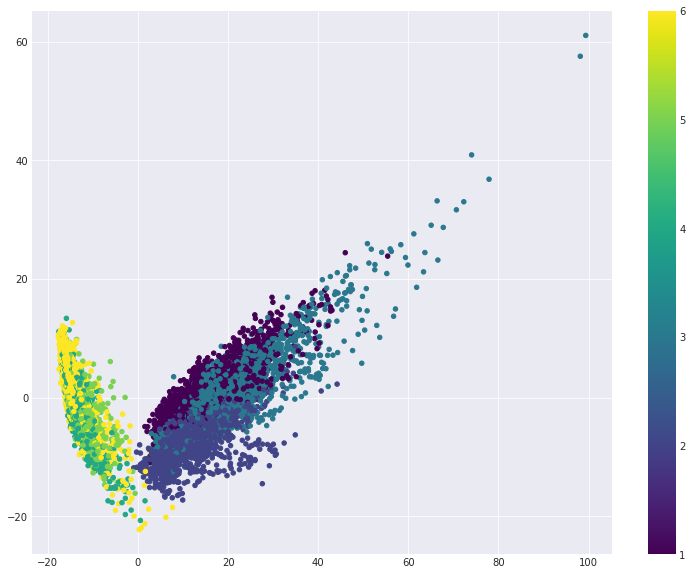

In [11]:
plt.figure(figsize=(13,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis');
plt.colorbar()#1.1

In [12]:
kmeans = MiniBatchKMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)
cluster_labels = kmeans.predict(X_pca)

In [13]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'підйом вгору сходами', 
             'спуск вниз сходами', 'сидіння', 'стояння', 'лежання', 'всі']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['всі']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,всі
ходьба,340,0,240,1017,125,0,1722
підйом вгору сходами,278,0,1075,179,12,0,1544
спуск вниз сходами,754,0,163,249,240,0,1406
сидіння,0,1631,33,0,0,113,1777
стояння,0,1896,10,0,0,0,1906
лежання,0,76,35,0,0,1833,1944
всі,1372,3603,1556,1445,377,1946,10299


C:\Users\tksw\AppData\Local\Temp\ipykernel_23228\1615400277.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(1, n_classes + 1)):


  0%|          | 0/6 [00:00<?, ?it/s]

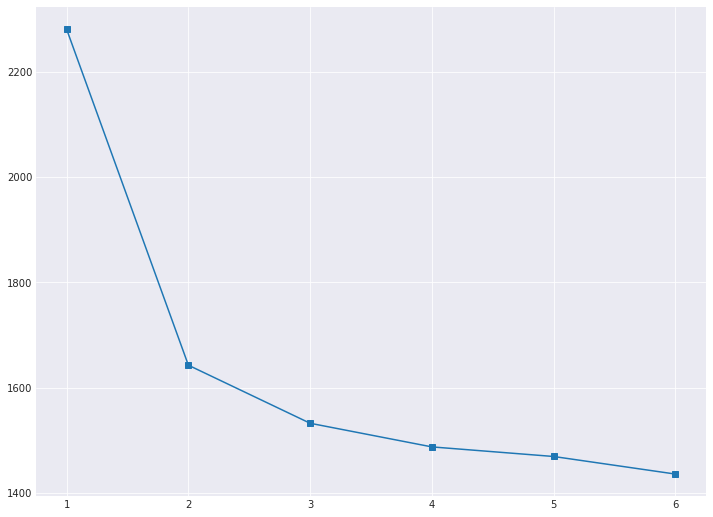

In [14]:
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = MiniBatchKMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE).fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 7), inertia, marker='s');

In [15]:
inertia = []
for k in tqdm_notebook(range(1, n_classes)):
    kmeans = MiniBatchKMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE).fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))

for i in range(1, len(inertia) - 1):
    D = abs(inertia[i] - inertia[i + 1]) / abs(inertia[i - 1] - inertia[i])
    print(D)#2 Оптимально 2 

C:\Users\tksw\AppData\Local\Temp\ipykernel_23228\3716966728.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(1, n_classes)):


  0%|          | 0/5 [00:00<?, ?it/s]

0.17285099347245256
0.4070139367455423
0.40583398074739485


In [16]:
ag = AgglomerativeClustering(n_clusters=n_classes, 
                             linkage='ward').fit_predict(X_pca)

In [17]:
metrics.adjusted_rand_score(y, ag)

0.49362763373004886

In [18]:
metrics.adjusted_rand_score(y, cluster_labels)

0.5342207745672404

In [19]:
#3
Для ARI немає значення, які саме значення мітки присвоєні кластерам, має значення лише розбиття об'єктів на кластери.
поясниш ебать)))0))

SyntaxError: invalid syntax (2956427868.py, line 2)

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [22]:
best_svc = GridSearchCV(svc, param_grid=svc_params, cv=3).fit(X_train_scaled, y_train)
best_svc = best_svc.best_estimator_

C:\Users\tksw\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\tksw\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\tksw\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\tksw\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\tksw\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\tksw\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

In [23]:
best_svc.C

0.1

In [24]:
y_predicted = best_svc.predict(X_test_scaled)

In [25]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'підйом вгору сходами', 'спуску вниз сходами', 
             'сидіння', 'стояння', 'лежання', 'всі']
tab.columns = tab.index
tab

,ходьба,підйом вгору сходами,спуску вниз сходами,сидіння,стояння,лежання,всі
ходьба,494,2,0,0,0,0,496
підйом вгору сходами,12,459,0,0,0,0,471
спуску вниз сходами,2,3,414,1,0,0,420
сидіння,0,4,0,426,61,0,491
стояння,0,0,0,15,517,0,532
лежання,0,0,0,0,11,526,537
всі,508,468,414,442,589,526,2947


In [27]:
metrics_ = metrics.classification_report(y_test, y_predicted, target_names=tab.index[:6])
print(metrics_)#4  

                      precision    recall  f1-score   support

              ходьба       0.97      1.00      0.98       496
підйом вгору сходами       0.98      0.97      0.98       471
 спуску вниз сходами       1.00      0.99      0.99       420
             сидіння       0.96      0.87      0.91       491
             стояння       0.88      0.97      0.92       532
             лежання       1.00      0.98      0.99       537

            accuracy                           0.96      2947
           macro avg       0.97      0.96      0.96      2947
        weighted avg       0.96      0.96      0.96      2947



In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [29]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [30]:
best_svc_pca = GridSearchCV(svc, param_grid=svc_params, cv=3).fit(X_train_pca, y_train)

C:\Users\tksw\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\tksw\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\tksw\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\tksw\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\tksw\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\tksw\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

In [31]:
y_predicted_pca = best_svc_pca.predict(X_test_pca)

In [32]:
tab = pd.crosstab(y_test, y_predicted_pca, margins=True)
tab.index = ['ходьба', 'підйом вгору сходами', 'спуску вниз сходами', 
             'сидіння', 'стояння', 'лежання', 'всі']
tab.columns = tab.index
tab

,ходьба,підйом вгору сходами,спуску вниз сходами,сидіння,стояння,лежання,всі
ходьба,485,6,4,0,0,1,496
підйом вгору сходами,45,408,18,0,0,0,471
спуску вниз сходами,9,26,383,0,1,1,420
сидіння,0,3,0,403,85,0,491
стояння,3,0,0,34,495,0,532
лежання,0,0,0,1,0,536,537
всі,542,443,405,438,581,538,2947


In [34]:
metrics_pca = metrics.classification_report(y_test, y_predicted_pca, target_names=tab.index[:6])
print(metrics_pca)#5



                      precision    recall  f1-score   support

              ходьба       0.89      0.98      0.93       496
підйом вгору сходами       0.92      0.87      0.89       471
 спуску вниз сходами       0.95      0.91      0.93       420
             сидіння       0.92      0.82      0.87       491
             стояння       0.85      0.93      0.89       532
             лежання       1.00      1.00      1.00       537

            accuracy                           0.92      2947
           macro avg       0.92      0.92      0.92      2947
        weighted avg       0.92      0.92      0.92      2947

